# Variational photos

Purpose of this exercise is to build and train a variational autoencoder on some image dataset. After that we'll want to check out how it performs on generating new images.

In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io
from skimage.util import img_as_ubyte
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(71)
np.random.seed(71)

# Dogs

The first choice is the [Stanford Dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). All images are divided into 120 dogs breeds but we won't use that split so we're going to flatten the directory structure. The dataset has been extracted and the main directory renamed to `dogs`.

In [2]:
dogs_path = 'datasets/dogs/'

In [3]:
def get_rid_of_subdirs(path):
    directories = list(os.listdir(path))
    n_total = len(directories)

    for i, directory in enumerate(directories):
        dir_path = path + directory + '/'
        for filename in os.listdir(dir_path):
            shutil.move(dir_path + filename, path)
        os.rmdir(dir_path)
        print(f'\r{i+1:4} / {n_total}', end='')

In [4]:
get_rid_of_subdirs(dogs_path)

 120 / 120

(-0.5, 394.5, 494.5, -0.5)

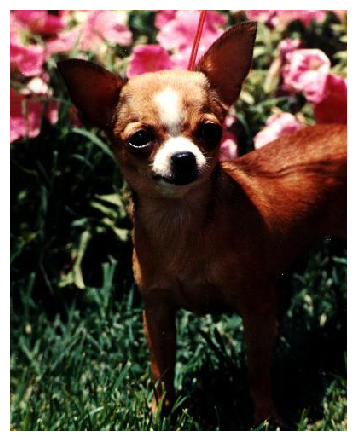

In [5]:
img = io.imread(dogs_path + 'n02085620_10131.jpg')

io.imshow(img)
plt.axis('off')

In [6]:
def make_shapes_df(path):
    filenames = os.listdir(path)
    n_total = len(filenames)

    shapes_list = []
    for i, filename in enumerate(filenames):
        shapes_list.append(io.imread(path + filename).shape)
        print(f'\r{i+1 : 5} / {n_total}', end='')

    df = pd.DataFrame(shapes_list, columns=['height', 'width', 'channels'])
    return df

In [7]:
dogs_shapes = make_shapes_df(dogs_path)
dogs_shapes.describe()

 20580 / 20580

height         width      channels
count  20580.000000  20580.000000  20580.000000
mean     385.861224    442.531876      3.000049
std      124.863446    142.792308      0.006971
min      100.000000     97.000000      3.000000
25%      333.000000    361.000000      3.000000
50%      375.000000    500.000000      3.000000
75%      453.000000    500.000000      3.000000
max     2562.000000   3264.000000      4.000000

It seems that shapes of the images varies much. In order to simplify the task to single model we'll resize them into one shape. Also we don't want to deform the pictures too much so the average height to width ratio should be preserved. The shape of 200 x 250 should be fine.

Also there are few images with 4 channels (RGBA). To simplify the preprocessing we'll get rid of those few examples and stick to 3 channels (RGB).

In [8]:
four_channels_imgs = dogs_shapes[dogs_shapes.channels == 4].index
four_channels_imgs

Int64Index([13680], dtype='int64')

In [9]:
four_channels_filename = os.listdir(dogs_path)[four_channels_imgs[0]]
four_channels_filename

'n02105855_2933.jpg'

In [10]:
os.remove(dogs_path + four_channels_filename)

In [11]:
dog_shape = (200, 250, 3)

(-0.5, 249.5, 199.5, -0.5)

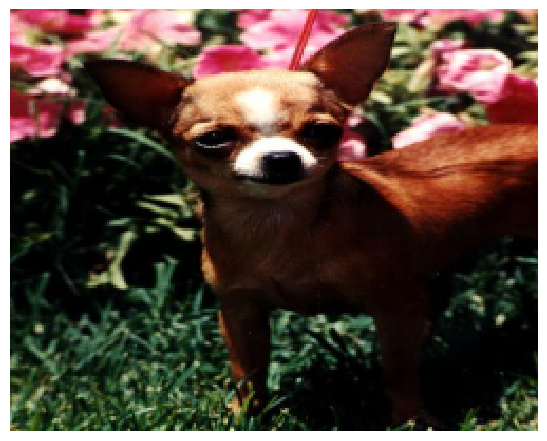

In [12]:
resized_img = resize(img, dog_shape)
io.imshow(resized_img)
plt.axis('off')

In [13]:
def reshape_images(path, new_shape):
    filenames = os.listdir(path)
    n_images = len(filenames)
    for i, filename in enumerate(filenames):
        filepath = path + filename
        old_image = io.imread(filepath)
        new_image = resize(old_image, new_shape[:-1])
        io.imsave(filepath, img_as_ubyte(new_image))
        print(f'\r{i+1 : 5} / {n_images}', end='')

In [14]:
reshape_images(dogs_path, dog_shape)

 20579 / 20579

## Dataset

In [15]:
dogs_dataset = keras.preprocessing.image_dataset_from_directory(
    dogs_path,
    labels=None,
    batch_size=32,
    image_size=dog_shape[:-1],
    seed=8
)
dogs_dataset = dogs_dataset.map(lambda x: (x / 255.0, x / 255.0)).shuffle(70).prefetch(1)

Found 20579 files belonging to 1 classes.


## Model

To build the autoencoder we're going to need some layer that will sample from normal distribution and adjust the samples accordingly creating codings.

The network's structure is arbitrary but we may look for different one if it fails to learn anything useful. As long as the model lowers loss at each iteration it is good enough. The latent loss has been prepared using common formula.

In [16]:
class SampleNormal(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return mean + tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2.0)

In [17]:
dogs_codings_size = 2700
conv_params = dict(padding='same', activation='selu', kernel_initializer='lecun_normal')

dogs_inputs = keras.layers.Input(shape=dog_shape)
dogs_enc_layer = keras.layers.Conv2D(8, kernel_size=9, strides=2, **conv_params)(dogs_inputs)  # 100 x 125 x 8
dogs_enc_layer = keras.layers.MaxPool2D(2, padding='same')(dogs_enc_layer)  # 50 x 63 x 8
dogs_enc_layer = keras.layers.Conv2D(32, kernel_size=9, strides=2, **conv_params)(dogs_enc_layer)  # 25 x 32 x 32
dogs_enc_layer = keras.layers.MaxPool2D(2, padding='same')(dogs_enc_layer)  # 13 x 16 x 32
dogs_enc_layer = keras.layers.Conv2D(64, kernel_size=5, **conv_params)(dogs_enc_layer)  # 13 x 16 x 64
dogs_enc_layer = keras.layers.MaxPool2D(2, padding='same')(dogs_enc_layer)  # 7 x 8 x 64
dogs_enc_layer = keras.layers.Flatten()(dogs_enc_layer)

dogs_means = keras.layers.Dense(dogs_codings_size)(dogs_enc_layer)
dogs_log_vars = keras.layers.Dense(dogs_codings_size)(dogs_enc_layer)
dogs_sampled_codings = SampleNormal()((dogs_means, dogs_log_vars))

dogs_encoder = keras.Model([dogs_inputs], [dogs_means, dogs_log_vars, dogs_sampled_codings])

In [18]:
dogs_decoder_inputs = keras.layers.Input(shape=(dogs_codings_size,))

dogs_dec_layer = keras.layers.Dense(7*8*64, input_shape=(dogs_codings_size,), activation='selu', kernel_initializer='lecun_normal')(dogs_decoder_inputs)
dogs_dec_layer = keras.layers.Reshape((7, 8, 64))(dogs_dec_layer)
dogs_dec_layer = keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, **conv_params, output_padding=(0, 1))(dogs_dec_layer)  # 13 x 16 x 32
dogs_dec_layer = keras.layers.Conv2DTranspose(8,  kernel_size=9, strides=4, **conv_params, output_padding=(1, 2))(dogs_dec_layer)  # 50 x 63 x 8
dogs_dec_layer = keras.layers.Conv2DTranspose(3,  kernel_size=9, strides=4, padding='same', activation='sigmoid', output_padding=(3, 1))(dogs_dec_layer)  # 200 x 250 x 3

dogs_decoder = keras.Model(dogs_decoder_inputs, dogs_dec_layer)

In [19]:
dogs_latent_loss = -0.5 * tf.reduce_sum(1.0 + dogs_log_vars - tf.exp(dogs_log_vars) - tf.square(dogs_means), axis=-1)

_, _, dogs_codings = dogs_encoder(dogs_inputs)
dogs_reconstructions = dogs_decoder(dogs_codings)
dogs_model = keras.Model(dogs_inputs, dogs_reconstructions)
dogs_model.add_loss(tf.reduce_mean(dogs_latent_loss) / (200*250*3))

In [20]:
def plot_samples(decoder, nrows=3, ncols=5, figsize=(10, 5)):
    codings_size = decoder.input_shape[1]
    random_imgs = decoder(tf.random.normal((nrows*ncols, codings_size))).numpy()
    random_imgs = (random_imgs - random_imgs.min()) / (random_imgs.max() - random_imgs.min())

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    for random_img, ax in zip(random_imgs, axs.ravel()):
        ax.imshow(random_img)
        ax.axis('off')

In [21]:
dogs_model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.0003),
    loss=keras.losses.MeanSquaredError()
)

Epoch 1/7
644/644 [==============================] - 889s 1s/step - loss: 0.0343
Epoch 2/7
644/644 [==============================] - 863s 1s/step - loss: 0.0238
Epoch 3/7
644/644 [==============================] - 868s 1s/step - loss: 0.0222
Epoch 4/7
644/644 [==============================] - 867s 1s/step - loss: 0.0212
Epoch 5/7
644/644 [==============================] - 867s 1s/step - loss: 0.0204
Epoch 6/7
644/644 [==============================] - 867s 1s/step - loss: 0.0199
Epoch 7/7
644/644 [==============================] - 869s 1s/step - loss: 0.0195


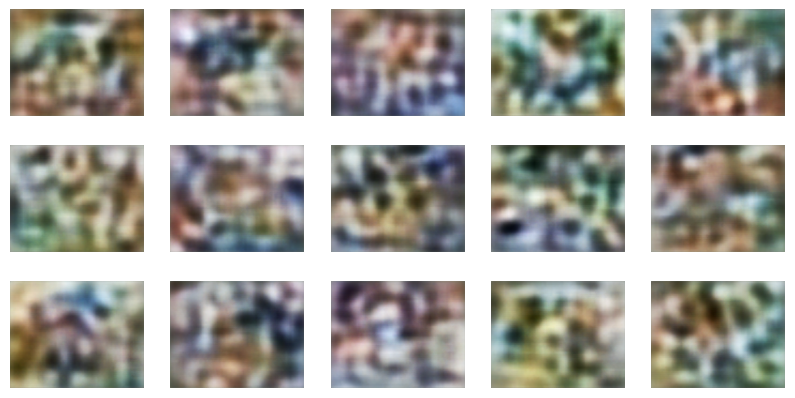

In [22]:
dogs_model.fit(dogs_dataset, epochs=7)
plot_samples(dogs_decoder)

The generated images don't look very convincing. Perhaps it's due to high variety of kinds of photos: taken from side/taken from front, one dog/more dogs, dog alone/dog with human etc.

Let's try with a different dataset.

# Faces

The dataset we'll look at now is [Labeled Faces in the Wild dataset](http://vis-www.cs.umass.edu/lfw/). The preprocessing is similar as before but this time there are no RGBA images to remove. Also the shape of each photo is the same so there's not need to resize them.

After a brief look it turns out that these photos are better suited for the task: most of them contain human face in the center and is taken from the front.

In [23]:
faces_path = 'datasets/lfw/'

get_rid_of_subdirs(faces_path)

5749 / 5749

(-0.5, 249.5, 249.5, -0.5)

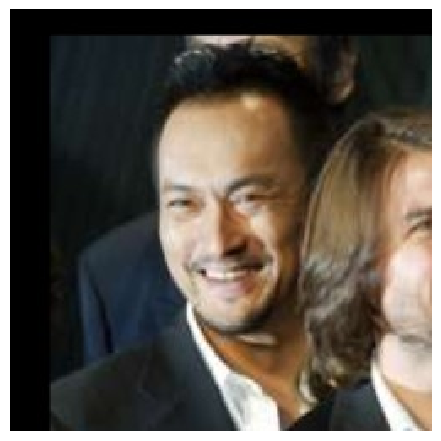

In [24]:
img = io.imread(faces_path + 'Ken_Watanabe_0002.jpg')

io.imshow(img)
plt.axis('off')

In [25]:
faces_shapes = make_shapes_df(faces_path)
faces_shapes.describe()

 13233 / 13233

height    width  channels
count  13233.0  13233.0   13233.0
mean     250.0    250.0       3.0
std        0.0      0.0       0.0
min      250.0    250.0       3.0
25%      250.0    250.0       3.0
50%      250.0    250.0       3.0
75%      250.0    250.0       3.0
max      250.0    250.0       3.0

In [26]:
face_shape = (250, 250, 3)

## Dataset

In [27]:
faces_dataset = keras.preprocessing.image_dataset_from_directory(
    faces_path,
    labels=None,
    batch_size=32,
    image_size=face_shape[:-1],
    seed=12
)
faces_dataset = faces_dataset.map(lambda x: (x / 255.0, x / 255.0)).shuffle(70).prefetch(1)

Found 13233 files belonging to 1 classes.


## Model

In [28]:
faces_codings_size = 2700
conv_params = dict(padding='same', activation='selu', kernel_initializer='lecun_normal')

faces_inputs = keras.layers.Input(shape=face_shape)
faces_enc_layer = keras.layers.Conv2D(8, kernel_size=9, strides=2, **conv_params)(faces_inputs)  # 125 x 125 x 8
faces_enc_layer = keras.layers.MaxPool2D(2, padding='same')(faces_enc_layer)  # 63 x 63 x 8
faces_enc_layer = keras.layers.Conv2D(32, kernel_size=9, strides=2, **conv_params)(faces_enc_layer)  # 32 x 32 x 32
faces_enc_layer = keras.layers.MaxPool2D(2, padding='same')(faces_enc_layer)  # 16 x 16 x 32
faces_enc_layer = keras.layers.Conv2D(64, kernel_size=5, **conv_params)(faces_enc_layer)  # 16 x 16 x 64
faces_enc_layer = keras.layers.MaxPool2D(2, padding='same')(faces_enc_layer)  # 8 x 8 x 64
faces_enc_layer = keras.layers.Flatten()(faces_enc_layer)

faces_means = keras.layers.Dense(faces_codings_size)(faces_enc_layer)
faces_log_vars = keras.layers.Dense(faces_codings_size)(faces_enc_layer)
faces_sampled_codings = SampleNormal()((faces_means, faces_log_vars))

faces_encoder = keras.Model([faces_inputs], [faces_means, faces_log_vars, faces_sampled_codings])

In [29]:
faces_decoder_inputs = keras.layers.Input(shape=(faces_codings_size,))
faces_dec_layer = keras.layers.Dense(8*8*64, input_shape=(faces_codings_size,), activation='selu', kernel_initializer='lecun_normal')(faces_decoder_inputs)
faces_dec_layer = keras.layers.Reshape((8, 8, 64))(faces_dec_layer)
faces_dec_layer = keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, **conv_params, output_padding=(1, 1))(faces_dec_layer)  # 16 x 16 x 32
faces_dec_layer = keras.layers.Conv2DTranspose(8,  kernel_size=9, strides=4, **conv_params, output_padding=(2, 2))(faces_dec_layer)  # 63 x 63 x 8
faces_dec_layer = keras.layers.Conv2DTranspose(3,  kernel_size=9, strides=4, padding='same', activation='sigmoid', output_padding=(1, 1))(faces_dec_layer)  # 250 x 250 x 3
faces_decoder = keras.Model(faces_decoder_inputs, faces_dec_layer)

faces_latent_loss = -0.5 * tf.reduce_sum(1.0 + faces_log_vars - tf.exp(faces_log_vars) - tf.square(faces_means), axis=-1)

_, _, faces_codings = faces_encoder(faces_inputs)
faces_reconstructions = faces_decoder(faces_codings)
faces_model = keras.Model(faces_inputs, faces_reconstructions)
faces_model.add_loss(tf.reduce_mean(faces_latent_loss) / (250*250*3))

In [30]:
faces_model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.0003),
    loss=keras.losses.MeanSquaredError()
)

Epoch 1/7
414/414 [==============================] - 675s 2s/step - loss: 0.0372
Epoch 2/7
414/414 [==============================] - 673s 2s/step - loss: 0.0232
Epoch 3/7
414/414 [==============================] - 671s 2s/step - loss: 0.0208
Epoch 4/7
414/414 [==============================] - 672s 2s/step - loss: 0.0196
Epoch 5/7
414/414 [==============================] - 673s 2s/step - loss: 0.0187
Epoch 6/7
414/414 [==============================] - 672s 2s/step - loss: 0.0180
Epoch 7/7
414/414 [==============================] - 672s 2s/step - loss: 0.0175


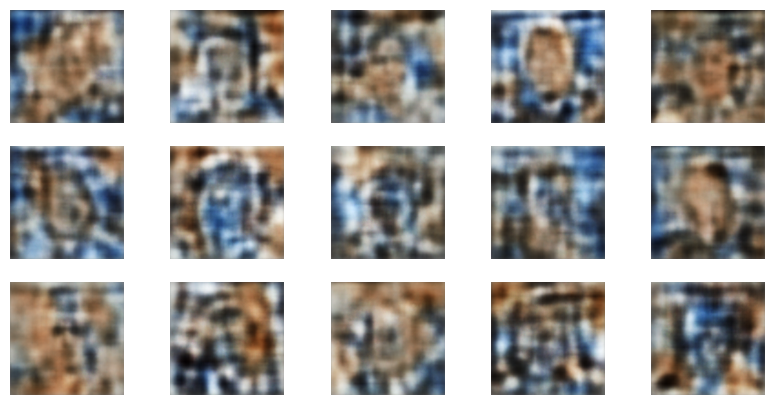

In [31]:
faces_model.fit(faces_dataset, epochs=7)
plot_samples(faces_decoder)

Generated images of faces are much better than those of dogs created with previous model. Here are a few examples containing shapes of people's faces in them while there was nothing similar to dog in the previous set. Although the overall performance still leaves a lot to desire, the network seems to have potential to produce images of people's faces. Probably using even bigger dataset of photos and training it for longer time would lead it to reasonable results.